In [2]:
from tensorflow.keras import datasets
import numpy as np

In [3]:
(X_train, y_train), (X_test, y_test) = datasets.fashion_mnist.load_data() #Load the fashion MNIST dataset

In [4]:
X_train.shape #60k images, 28x28 grayscale image

(60000, 28, 28)

In [5]:
#Rescale the values within [0,1]
X_train_rescale = X_train.astype('float32')/255.0
X_test_rescale = X_test.astype('float32')/255.0

In [6]:
X_train_rescale.shape

(60000, 28, 28)

In [7]:
y_train.shape #60k labels

(60000,)

In [8]:
np.unique(y_train, return_counts=True) #10 unique labels

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000],
       dtype=int64))

In [9]:
import matplotlib.pyplot as plt

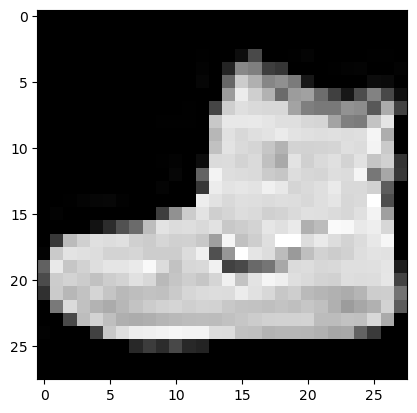

In [10]:
plt.imshow(X_train[0], cmap = 'gray')

In [11]:
from tensorflow.keras.utils import to_categorical

In [12]:
#One hot encoding
y_train_ohe = to_categorical(y_train)
y_test_ohe = to_categorical(y_test)

In [13]:
y_train_ohe.shape

(60000, 10)

In [14]:
from tensorflow.keras import models, layers, optimizers

In [15]:
#Build a model without Hyperparameter tuning

model = models.Sequential()
model.add(layers.Flatten(input_shape=(28, 28)))
model.add(layers.Dense(8, activation = 'sigmoid'))
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\slywi\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
history = model.fit(X_train_rescale, y_train_ohe, validation_split=0.2, epochs=20)

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5342 - loss: 1.5918 - val_accuracy: 0.7464 - val_loss: 0.8160
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7651 - loss: 0.7510 - val_accuracy: 0.7929 - val_loss: 0.6144
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8075 - loss: 0.5820 - val_accuracy: 0.8255 - val_loss: 0.5262
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8328 - loss: 0.5052 - val_accuracy: 0.8367 - val_loss: 0.4864
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8418 - loss: 0.4739 - val_accuracy: 0.8411 - val_loss: 0.4627
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8495 - loss: 0.4418 - val_accuracy: 0.8447 - val_loss: 0.4487
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8536 - loss: 0.4322 - val_accuracy: 0.8438 - val_loss: 0.4510
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8520 - loss: 0.4268 - 

In [17]:
acc = model.evaluate(X_test_rescale, y_test_ohe)[1]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8447 - loss: 0.4472


In [18]:
print("Accuracy without tuning: ", acc)

Accuracy without tuning:  0.8414000272750854


In [19]:
#Build hypermodel

def hp_model(hp):
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28))) 

    hidden_nums = hp.Int('hidden_nums', min_value=1, max_value=3)

    for i in range(hidden_nums):
        units = hp.Int(f'units_{i}', 64, 512, step=64)
        activation = hp.Choice(f'activation_{i}', ['sigmoid','relu', 'tanh'])
        model.add(layers.Dense(units=units, activation=activation))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(hp.Float(f'dropout_{i}', 0.2, 0.4, step=0.1)))
    
    model.add(layers.Dense(units=10, activation='softmax'))
   
    model.compile(
        optimizer=optimizers.Adam(hp.Choice('lr', [1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model

In [20]:
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping

In [29]:
#Hyperband and Ealystopping

#Hyperband tuner
tuner =  kt.BayesianOptimization(hypermodel=hp_model, objective='val_accuracy', max_trials=30, directory='D/DPL', project_name='4')

#Ealry Stopping
stop_early = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [31]:
#Start tuning
tuner.search(X_train_rescale, y_train_ohe, validation_split=0.2, epochs=10, batch_size=64, callbacks=[stop_early])

Trial 30 Complete [00h 00m 53s]
val_accuracy: 0.8849999904632568

Best val_accuracy So Far: 0.887499988079071
Total elapsed time: 00h 31m 20s


In [33]:
#Get best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

num_hidden_layers = best_hps.get('hidden_nums')
print(f"Number of hidden layers: {num_hidden_layers}")

for i in range(num_hidden_layers):
    units = best_hps.get(f'units_{i}')
    activation = best_hps.get(f'activation_{i}')
    print(f"Layer {i+1}: {units} neurons, activation = {activation}")

lr = best_hps.get('lr')
print(f"Learning rate: {lr}")

Number of hidden layers: 2
Layer 1: 384 neurons, activation = relu
Layer 2: 448 neurons, activation = relu
Learning rate: 0.0001


In [35]:
#Build model with tuned Hyperparameters
hyper_model = tuner.hypermodel.build(best_hps)

In [37]:
hyper_model_fit = hyper_model.fit(x=X_train_rescale, y=y_train_ohe, epochs=20, validation_split=0.2, callbacks=[stop_early])

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.7172 - loss: 0.8608 - val_accuracy: 0.8552 - val_loss: 0.4182
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8339 - loss: 0.4776 - val_accuracy: 0.8637 - val_loss: 0.3733
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8516 - loss: 0.4121 - val_accuracy: 0.8734 - val_loss: 0.3517
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8585 - loss: 0.3898 - val_accuracy: 0.8786 - val_loss: 0.3430
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8655 - loss: 0.3608 - val_accuracy: 0.8782 - val_loss: 0.3391
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8757 - loss: 0.3395 - val_accuracy: 0.8774 - val_loss: 0.3466
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8792 - loss: 0.3302 - val_accuracy: 0.8853 - val_loss: 0.3262
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8855 - loss: 0

In [39]:
#Accuracy after Hyperparameter tuning
eva = hyper_model.evaluate(x=X_test_rescale, y=y_test_ohe)[1]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8885 - loss: 0.3204


In [41]:
print("Accuracy after tuning: ", eva)

Accuracy after tuning:  0.8910999894142151
